In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, interpolate
import casadi as ca

In [6]:
import pypei
from importlib import reload
reload(pypei)

<module 'pypei' from 'C:\\Users\\dwu\\REPOS\\pypei\\pypei\\__init__.py'>

In [7]:
%matplotlib inline

## Yanking from
https://github.com/CardiacModelling/FourWaysOfFitting/blob/main/model-and-protocols/beattie-2017-ikr-hh.mmt

In [8]:
volt_ts, volts = np.genfromtxt("./protocol-staircaseramp.csv", skip_header=1, dtype=float, delimiter=',').T

In [9]:
volt_fn = interpolate.interp1d(volt_ts, volts, kind='previous')
volt_ca = ca.interpolant('volts', 'linear', [volt_ts], volts)

In [10]:
def V_np(t):
#     return -80 + ca.floor(t/1000) * 20 + ca.mod(ca.floor(t/500), 2) * -10
    return volt_fn(t/1000)

In [11]:
def V_ca(t):
    return volt_ca(t/1000)

In [12]:
V = V_np

In [13]:
# V = -80 #mV
EK = -88.4 #mV

def ion_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*ca.exp(p[1]*V(t))
    k2 = p[2]*ca.exp(-p[3]*V(t))
    k3 = p[4]*ca.exp(p[5]*V(t))
    k4 = p[6]*ca.exp(-p[7]*V(t))
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]

In [14]:
def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V(t) - EK)

In [15]:
y0 = [ # a, r
    0, 1]

p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

In [16]:
tlim = [0, 15_000]
ts = np.linspace(*tlim, tlim[-1])

In [17]:
ar_sol = integrate.solve_ivp(ion_model, tlim, y0, args=[p_true], dense_output=True)

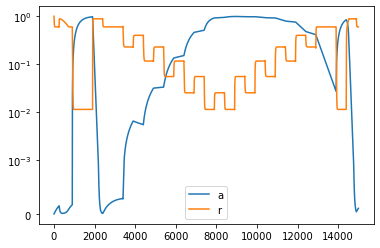

In [18]:
plt.figure()
plt.plot(ts, ar_sol.sol(ts).T, label=['a', 'r'])
plt.yscale('symlog', linthresh=1e-3)
# for yi in ar_sol.t:
#     plt.axvline(yi, color='k', lw=0.1)
plt.legend()

In [19]:
ar_sol_a, ar_sol_r = ar_sol.sol(ts)

In [20]:
ar_O = ar_sol_a*ar_sol_r
ar_I = ar_sol_a*(1-ar_sol_r)
ar_C = (1-ar_sol_a)*ar_sol_r
ar_IC = (1-ar_sol_a)*(1-ar_sol_r)
ar_stack = np.vstack([ar_O, ar_I, ar_C, ar_IC])


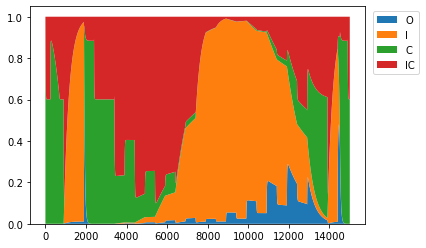

In [21]:
plt.figure()
plt.stackplot(ts, ar_stack, labels=['O', 'I', 'C', 'IC'])
plt.legend(bbox_to_anchor=[1.01, 1], loc='upper left')

Text(0.5, 0, 't (ms)')

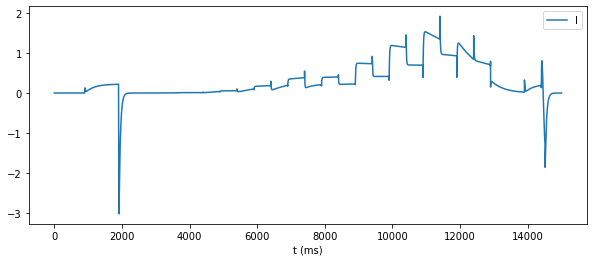

In [22]:
plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

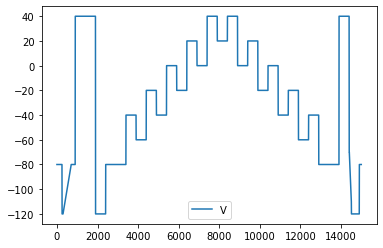

In [23]:
plt.figure()
plt.plot(ts, V(ts))
plt.legend('V')

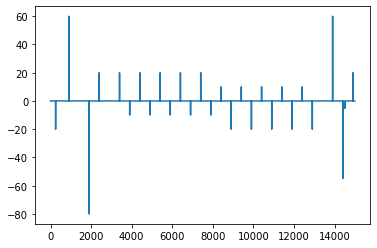

In [24]:
plt.figure()
plt.plot(ts, np.gradient(V(ts), ts))

## Testing casadi compat with V(t)

In [25]:
import process_volts_again as pva
from importlib import reload

reload(pva)

<module 'process_volts_again' from 'C:\\Users\\dwu\\REPOS\\ionch\\process_volts_again.py'>

In [26]:
n_grid = 400

In [27]:
pf400 = pva.expanded_fn(n_grid)

# pre discretise V
def V_discr(t):
    return pf400(np.linspace(*tlim, n_grid)/1000).T


def VX(t):
    return pf400(t/1000)

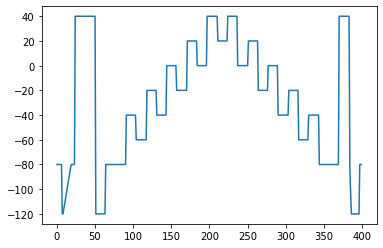

In [28]:
plt.plot(V_discr(None))

In [29]:
change_points = np.genfromtxt('staircase.changes', skip_header=1, delimiter=',')

In [200]:
cpx = [*(change_points[:,0]*1000), tlim[-1]]
kloc = [ii for i,j in zip(cpx[:-1], cpx[1:]) for ii in [i]*4 + list(np.array([0.25, 0.5, 0.75])*(j-i) + i)] + [tlim[-1]]

In [201]:
bf = pypei.functions.casbasis.basis_functions(kloc)

In [34]:
%matplotlib notebook

<IPython.core.display.Javascript object>


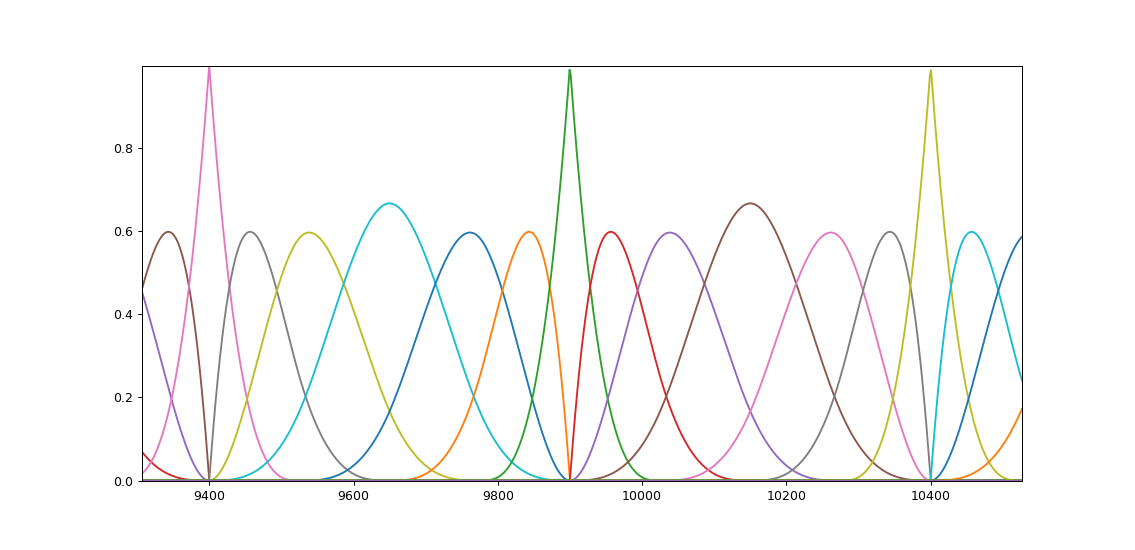

In [202]:
plt.figure()
for bfi in bf:
    plt.plot(np.linspace(*tlim, 10_000), bfi(np.linspace(*tlim, 10_000)))
plt.axvline(tlim[-1], color='k')

note here that the restriction on V being prediscretised means 
that the observational points must necessarily be a strict subset of 
the collocation points.

In [37]:
V = V_discr

In [203]:
kf_gen = lambda *x: kloc

# mdl_config = {
#     'grid_size': n_grid,
#     'basis_number': 130,
#     'model': ion_model,
#     'model_form': {
#         'state': 2,
#         'parameters': 9,
#     },
#     'time_span': tlim,
#     'knot_function': kf_gen,
#     'dataset': None,
# }

# splmdl = pypei.modeller.Model(configuration=mdl_config)

In [204]:
problem = pypei.Problem()

In [206]:
problem.build_model(
    model_fn=ion_model,
    model_form = {
        'state': 2,
        'parameters': 9,
    },
    time_span=tlim,
    grid_size=n_grid,
    knot_fn=kf_gen,
    basis_number=195,
)

In [207]:
def obsv_ca(t, y, p):
    a, r = ca.horzsplit(y, 1)
    *p_, g = p
    return g * a * r * (V_discr(t) - EK)
    

In [208]:
interpolant = obsv_ca(problem.model.observation_times, problem.model.all_x_at(problem.model.cs, problem.model.observation_times), problem.model.ps)

In [209]:
# generate synthetic data
truth_synth = obsv(problem.model.observation_times, ar_sol.sol(problem.model.observation_times), p_true)

y_synth = (truth_synth * (1 + 0.00*np.random.randn(*truth_synth.shape))).toarray()

<IPython.core.display.Javascript object>


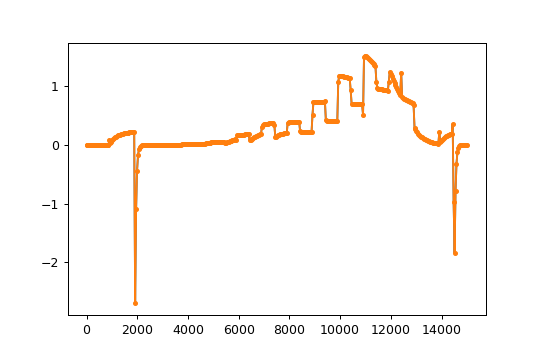

In [210]:
plt.figure()
plt.plot(problem.model.observation_times, y_synth)
plt.plot(problem.model.observation_times, truth_synth, marker='.')

# plt.ylim(-1, 2)

In [213]:
# manually build data objects
problem.data_time = problem.model.observation_times
problem.data_orig = y_synth
problem.data = y_synth

problem.interpolator = interpolant

In [214]:
model_struct = {
    'order':'ar',
    'inherent_order': 'ar',
}

problem.build_objective(model_struct, False,[
    {
        'sz': (1, 1),
        'obs_fn': problem.model.ps[-1],
    },
    {
        'n': 1,
        'balance': False,
        'iid': True,
    }
])

In [215]:
# manually assemble objective to assume iid noise along timeseries

problem.objective_config['L'][0] = {
    'n': np.prod(problem.data.shape),
    'iid': True,
    'balance': False,
}

problem.objective = pypei.objective.Objective()
problem.objective.make(problem.objective_config)

In [216]:
problem.build_solver(constraint_opts={'lbg': [0]*400+[1]+[0]*399, 'ubg': [0]+[1]*(399+400), 
                                      }, 
                     guess_opts={'x0': 0.5}, w0=[1,1,1,100])

In [217]:
def p_wreg(w, y):
    return [*pypei.Problem.p(w, y), 0.15]

problem.p = p_wreg

In [218]:
def struct_weight_2(residuals):
    ws = []
    # deal with data weights
#     for s in problem.objective_config['L'][0]['struct']:
    ws.append(problem.gaussian_w(residuals[0], problem.objective_config['L'][0]['n']))
    # deal with model weights
    for s in problem.objective_config['L'][1]['struct']:
        if 'i0s' in s:
            rs = ca.vcat([residuals[1][i0:i0+n] for n, i0 in zip(s['ns'], s['i0s'])])
            ws.append(problem.gaussian_w(rs, sum(s['ns'])))
        else:
            ws.append(problem.gaussian_w(residuals[1][s['i0']:s['i0']+s['n']], s['n']))
    ws.append(max(np.max(ws)*2, 100))
    return ws


problem.weight_fn = struct_weight_2

In [219]:
sln = problem.solve()

Iteration: 0
This is Ipopt version 3.14.8, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:     3186
Number of nonzeros in Lagrangian Hessian.............:     4145

Total number of variables............................:      399
                     variables with only lower bounds:        9
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      798
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6405284e+22 7.86e-01 6.02e+16  -1.0 0.00e+00    -  0.00e+

CasADi - 2022-09-29 17:25:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-29 17:25:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-29 17:25:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]


 100  1.4335817e+00 0.00e+00 8.77e-06 -12.9 4.45e-02  -7.6 1.00e+00 1.00e+00f  1 

Number of Iterations....: 109

                                   (scaled)                 (unscaled)
Objective...............:   6.5800094078274634e-09    6.5800094078274629e-01
Dual infeasibility......:   9.3763932853583725e-09    9.3763932853583720e-01
Constraint violation....:   7.3468396926392969e-40    7.3468396926392969e-40
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2571451341927959e-13    1.2571451341927959e-05
Overall NLP error.......:   9.3763932853583725e-09    9.3763932853583720e-01


Number of objective function evaluations             = 131
Number of objective gradient evaluations             = 110
Number of equality constraint evaluations            = 131
Number of inequality constraint evaluations          = 131
Number of equality constraint Jacobian evaluations   = 110
Number of inequality constraint Jacobian evaluations = 1

C:\Users\dwu\REPOS\pypei\pypei\irls_fitter.py:233: StepControlWarning: Log-Likelihood is not improving: 1.0
  warnings.warn(f"Log-Likelihood is not improving: {err}", category=Solver.StepControlWarning)


  50  2.1809420e+01 1.20e-38 1.65e-01  -3.8 5.31e-02  -2.2 1.00e+00 1.00e+00f  1 
 100  1.4855921e+01 2.35e-38 4.20e-02  -5.7 1.93e+02 -10.7 1.00e+00 1.00e+00f  1 
 150  1.4783160e+01 4.16e-40 2.16e-02  -8.6 1.13e-02  -5.8 1.00e+00 1.00e+00f  1 
 200  1.4778802e+01 2.25e-39 1.05e-02  -8.6 4.63e-02 -12.5 1.00e+00 6.25e-02h  5 
Cannot call restoration phase at point that is almost feasible (violation 1.893266e-29).
Abort in line search due to no other fall back.

Number of Iterations....: 243

                                   (scaled)                 (unscaled)
Objective...............:   1.5394329764172279e-02    1.4778131282354924e+01
Dual infeasibility......:   1.8213737006651298e-02    1.7484684344817367e+01
Constraint violation....:   1.8932661725286750e-29    1.8932661725286750e-29
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8564936583186831e-09    2.7421549971011373e-06
Overall NLP error.......:   1.8213737006651298e

<IPython.core.display.Javascript object>


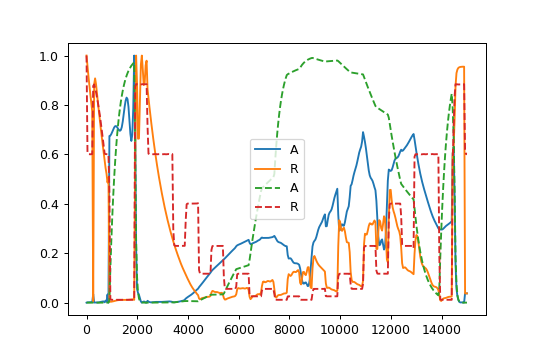

In [220]:
plt.figure()
plt.plot(problem.model.observation_times, problem.get_state(sln['shist'][1]), label=list('AR'))
plt.plot(problem.model.observation_times,  ar_sol.sol(problem.model.observation_times).T, '--', label=list('AR'))
plt.legend()

<IPython.core.display.Javascript object>


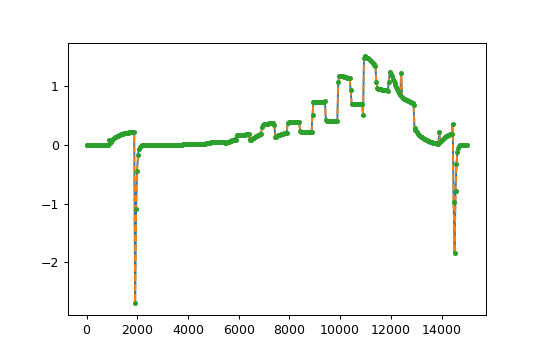

In [221]:
plt.figure()
ex_idx = -1
plt.plot(problem.model.observation_times,
         obsv_ca(problem.model.observation_times, problem.get_state(sln['shist'][ex_idx]), problem.get_parameters(sln['shist'][ex_idx])))
plt.plot(problem.model.observation_times, truth_synth, '--')
plt.plot(problem.model.observation_times, y_synth, '.')

In [199]:
[problem.get_parameters(x) for x in sln['shist']]

[(DM(0.000169496),
  DM(0.000677974),
  DM(0.000292533),
  DM(0.0336845),
  DM(0.00209174),
  DM(0.000112245),
  DM(0.000394342),
  DM(0.00218517),
  DM(0.149997)),
 (DM(6.35599e-08),
  DM(0.108442),
  DM(0.000224669),
  DM(0.0380756),
  DM(0.00560971),
  DM(0.0158781),
  DM(0.00466477),
  DM(0.0392598),
  DM(0.152649)),
 (DM(1.89397e-06),
  DM(0.0712001),
  DM(0.000144777),
  DM(0.0417657),
  DM(0.0049949),
  DM(0.0175542),
  DM(0.00378176),
  DM(0.0452803),
  DM(0.15265)),
 (DM(1.46045e-05),
  DM(-5.4655e-09),
  DM(0.00033565),
  DM(0.0346856),
  DM(0.00474707),
  DM(0.0193156),
  DM(0.0102786),
  DM(0.0162925),
  DM(0.151065)),
 (DM(2.18969e-05),
  DM(-6.46343e-09),
  DM(0.000422967),
  DM(0.0327526),
  DM(0.00314417),
  DM(0.020354),
  DM(0.0111859),
  DM(0.0109088),
  DM(0.150285)),
 (DM(2.81623e-05),
  DM(-8.28736e-09),
  DM(0.000582903),
  DM(0.0300746),
  DM(0.00127388),
  DM(0.0331547),
  DM(0.0110307),
  DM(0.00790343),
  DM(0.150085))]

In [191]:
p_true

[0.000226,
 0.0699,
 3.45e-05,
 0.05462,
 0.0873,
 0.00891,
 0.00515,
 0.03158,
 0.1524]

<IPython.core.display.Javascript object>


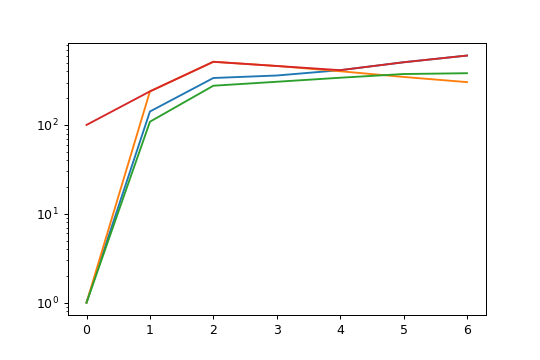

In [192]:
plt.figure()
plt.semilogy(ca.hcat(sln['whist'])[:,:].T);

In [174]:
model_discr = ca.Function('model_discr', [problem.solver.decision_vars, problem.solver.parameters], 
                          [problem.objective.us_obj_fn(0), problem.objective.us_obj_fn(1)])

In [175]:
model_discr(sln['shist'][1]['x'], problem.p(sln['whist'][1], problem.data))

(DM(0.025597), DM(6.39396e-05))

In [176]:
sln['whist']

[[1, 1, 1, 1],
 [5.068216310370666, 93.27275804203494, 84.8301519319097, 1],
 [125.00727406914223, 2677.1519623931977, 7014.58254753774, 1],
 [158.37454139892813, 8499.282090352652, 61130.68778243462, 1],
 [0.08577470324478653, 6.061737384823146e-31, 0.004005935962556512, 1],
 [60.32831036967381, 1.0834697850852061e-25, 60.87564912363961, 1],
 [2634.1640497276994, 7.35530314158461e-21, 2434.4364446579325, 1]]

In [ ]:
## try idea of Joes to normalise the observations by the voltages. or V -EK

